In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
#import api_wrapper as wrap
from api_wrapper import alph_api_wrapper as alph 
from api_wrapper import alph_settings

In [133]:
a_s = alph_settings(apikey = "TACZtZi8hd383vPZAVTsyxKLrbSaCdvqK6", site = "https://www.alphavantage.co/query?")

In [135]:
#test case on IBM
function = "TIME_SERIES_INTRADAY_EXTENDED"
ticker_lst = ["IBM", "HPQ"]
interval = "60min"
slice = [f"year1month{i}" for i in range(1, 10)] #first three months of intraday data
outputsize = "compact"
test = alph.intraday_url(a_s, function, ticker_lst, interval, slice = slice, outputsize = outputsize)

ibm_url = test["IBM"][0]
ibm_obj = alph.get_csv_data(ibm_url, pretty_print = False)

hp_url = test["HPQ"][0]
hp_obj = alph.get_csv_data(hp_url, pretty_print = False)

In [136]:
mth = len(test_obj)/3 #per month 
day = mth/30 #per day
t_hr = day/8 #per trading hour
print(mth, day, t_hr)

82.33333333333333 2.7444444444444445 0.34305555555555556


In [137]:
import pandas as pd 
ibm_df = pd.DataFrame(ibm_obj[1:], columns = ['time', 'open', 'high', 'low', 'close', 'volume'])
hp_df = pd.DataFrame(hp_obj[1:], columns = ['time', 'open', 'high', 'low', 'close', 'volume'])

In [138]:
ibm_df

,time,open,high,low,close,volume
0,2022-10-03 20:00:00,121.87,121.87,121.52,121.52,225
1,2022-10-03 19:00:00,121.53,121.53,121.53,121.53,100
2,2022-10-03 18:00:00,121.7,121.7,121.54,121.55,852
3,2022-10-03 17:00:00,121.51,121.52,121.49,121.51,171607
4,2022-10-03 16:00:00,122.11,122.13,121.435,121.51,939269
...,...,...,...,...,...,...
241,2022-09-06 12:00:00,127.49,127.89,127.16,127.45,331507
242,2022-09-06 11:00:00,127.22,127.69,126.42,127.55,552853
243,2022-09-06 10:00:00,127.8,128.06,126.89,127.28,425086
244,2022-09-06 09:00:00,128.0,128.7,128.0,128.1209,1623


In [141]:
data = pd.DataFrame()
data['time'] = ibm_df['time']
data['ibm_vol'] = ibm_df['volume'].astype('float64')
data['hp_vol'] = hp_df['volume'].astype('float64')
data['spread'] = ibm_df['close'].astype('float64') - hp_df['close'].astype('float64')
data['spread_high'] = ibm_df['high'].astype('float64') - hp_df['high'].astype('float64')
data.sort_values('time', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False)
data.reset_index(inplace= True)
data = data[['time','ibm_vol','hp_vol','spread','spread_high']]
data

,time,ibm_vol,hp_vol,spread,spread_high
0,2022-09-06 05:00:00,250.0,1186529.0,100.672481,100.276156
1,2022-09-06 09:00:00,1623.0,2171914.0,100.928059,101.462573
2,2022-09-06 10:00:00,425086.0,2122932.0,99.780007,100.396523
3,2022-09-06 11:00:00,552853.0,1399315.0,100.322481,100.185053
4,2022-09-06 12:00:00,331507.0,1110879.0,100.480092,100.642664
...,...,...,...,...,...
241,2022-10-03 16:00:00,939269.0,1117254.0,95.415000,96.020000
242,2022-10-03 17:00:00,171607.0,2188167.0,95.620000,95.420000
243,2022-10-03 18:00:00,852.0,163074.0,95.660000,95.810000
244,2022-10-03 19:00:00,100.0,509.0,95.659300,95.590000


In [142]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,ibm_vol,hp_vol,spread,spread_high
ibm_vol,1.000000,0.265407,-0.081122,-0.022132
hp_vol,0.265407,1.000000,0.091738,0.112691
spread,-0.081122,0.091738,1.000000,0.983654
spread_high,-0.022132,0.112691,0.983654,1.000000


In [143]:
data.dropna(inplace = True)

In [145]:
import numpy as np
def gen_labels(df,t,threshold):
    # Calculate % return on spread t hours later
    df['forward_return'] = df['spread'].diff(periods=t)/df['spread']
    
    #If the return is more than x%, we should have bought, and hence the label is (1)
    #If return is less than x%, we should have sold, and hence label is (-1)
    #If in between, do nothing (0)
    df['output'] = np.select([df['forward_return'] > threshold ,df['forward_return'] < -threshold],[1,-1])
    return df

data = gen_labels(data,t=24,threshold=0.02)

In [146]:
split = round(0.8*len(data))
train, test = data[:split],data[split:]

In [147]:
x_train = train[['ibm_vol','hp_vol','spread']]
y_train = train[['output']]

x_test = test[['ibm_vol','hp_vol','spread']]
y_test = test[['output']]


In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# model = RandomForestClassifier(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  7.1min finished
C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}

In [152]:
model = RandomForestClassifier(bootstrap= True,
                             max_depth= 80,
                             max_features= 2,
                             min_samples_leaf= 4,
                             min_samples_split= 8,
                             n_estimators=100,
                             random_state = 42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

<ipython-input-152-d82058ad26e6>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


In [153]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.22      0.78      0.34         9
           0       0.88      0.38      0.53        40

    accuracy                           0.45        49
   macro avg       0.55      0.58      0.43        49
weighted avg       0.76      0.45      0.49        49



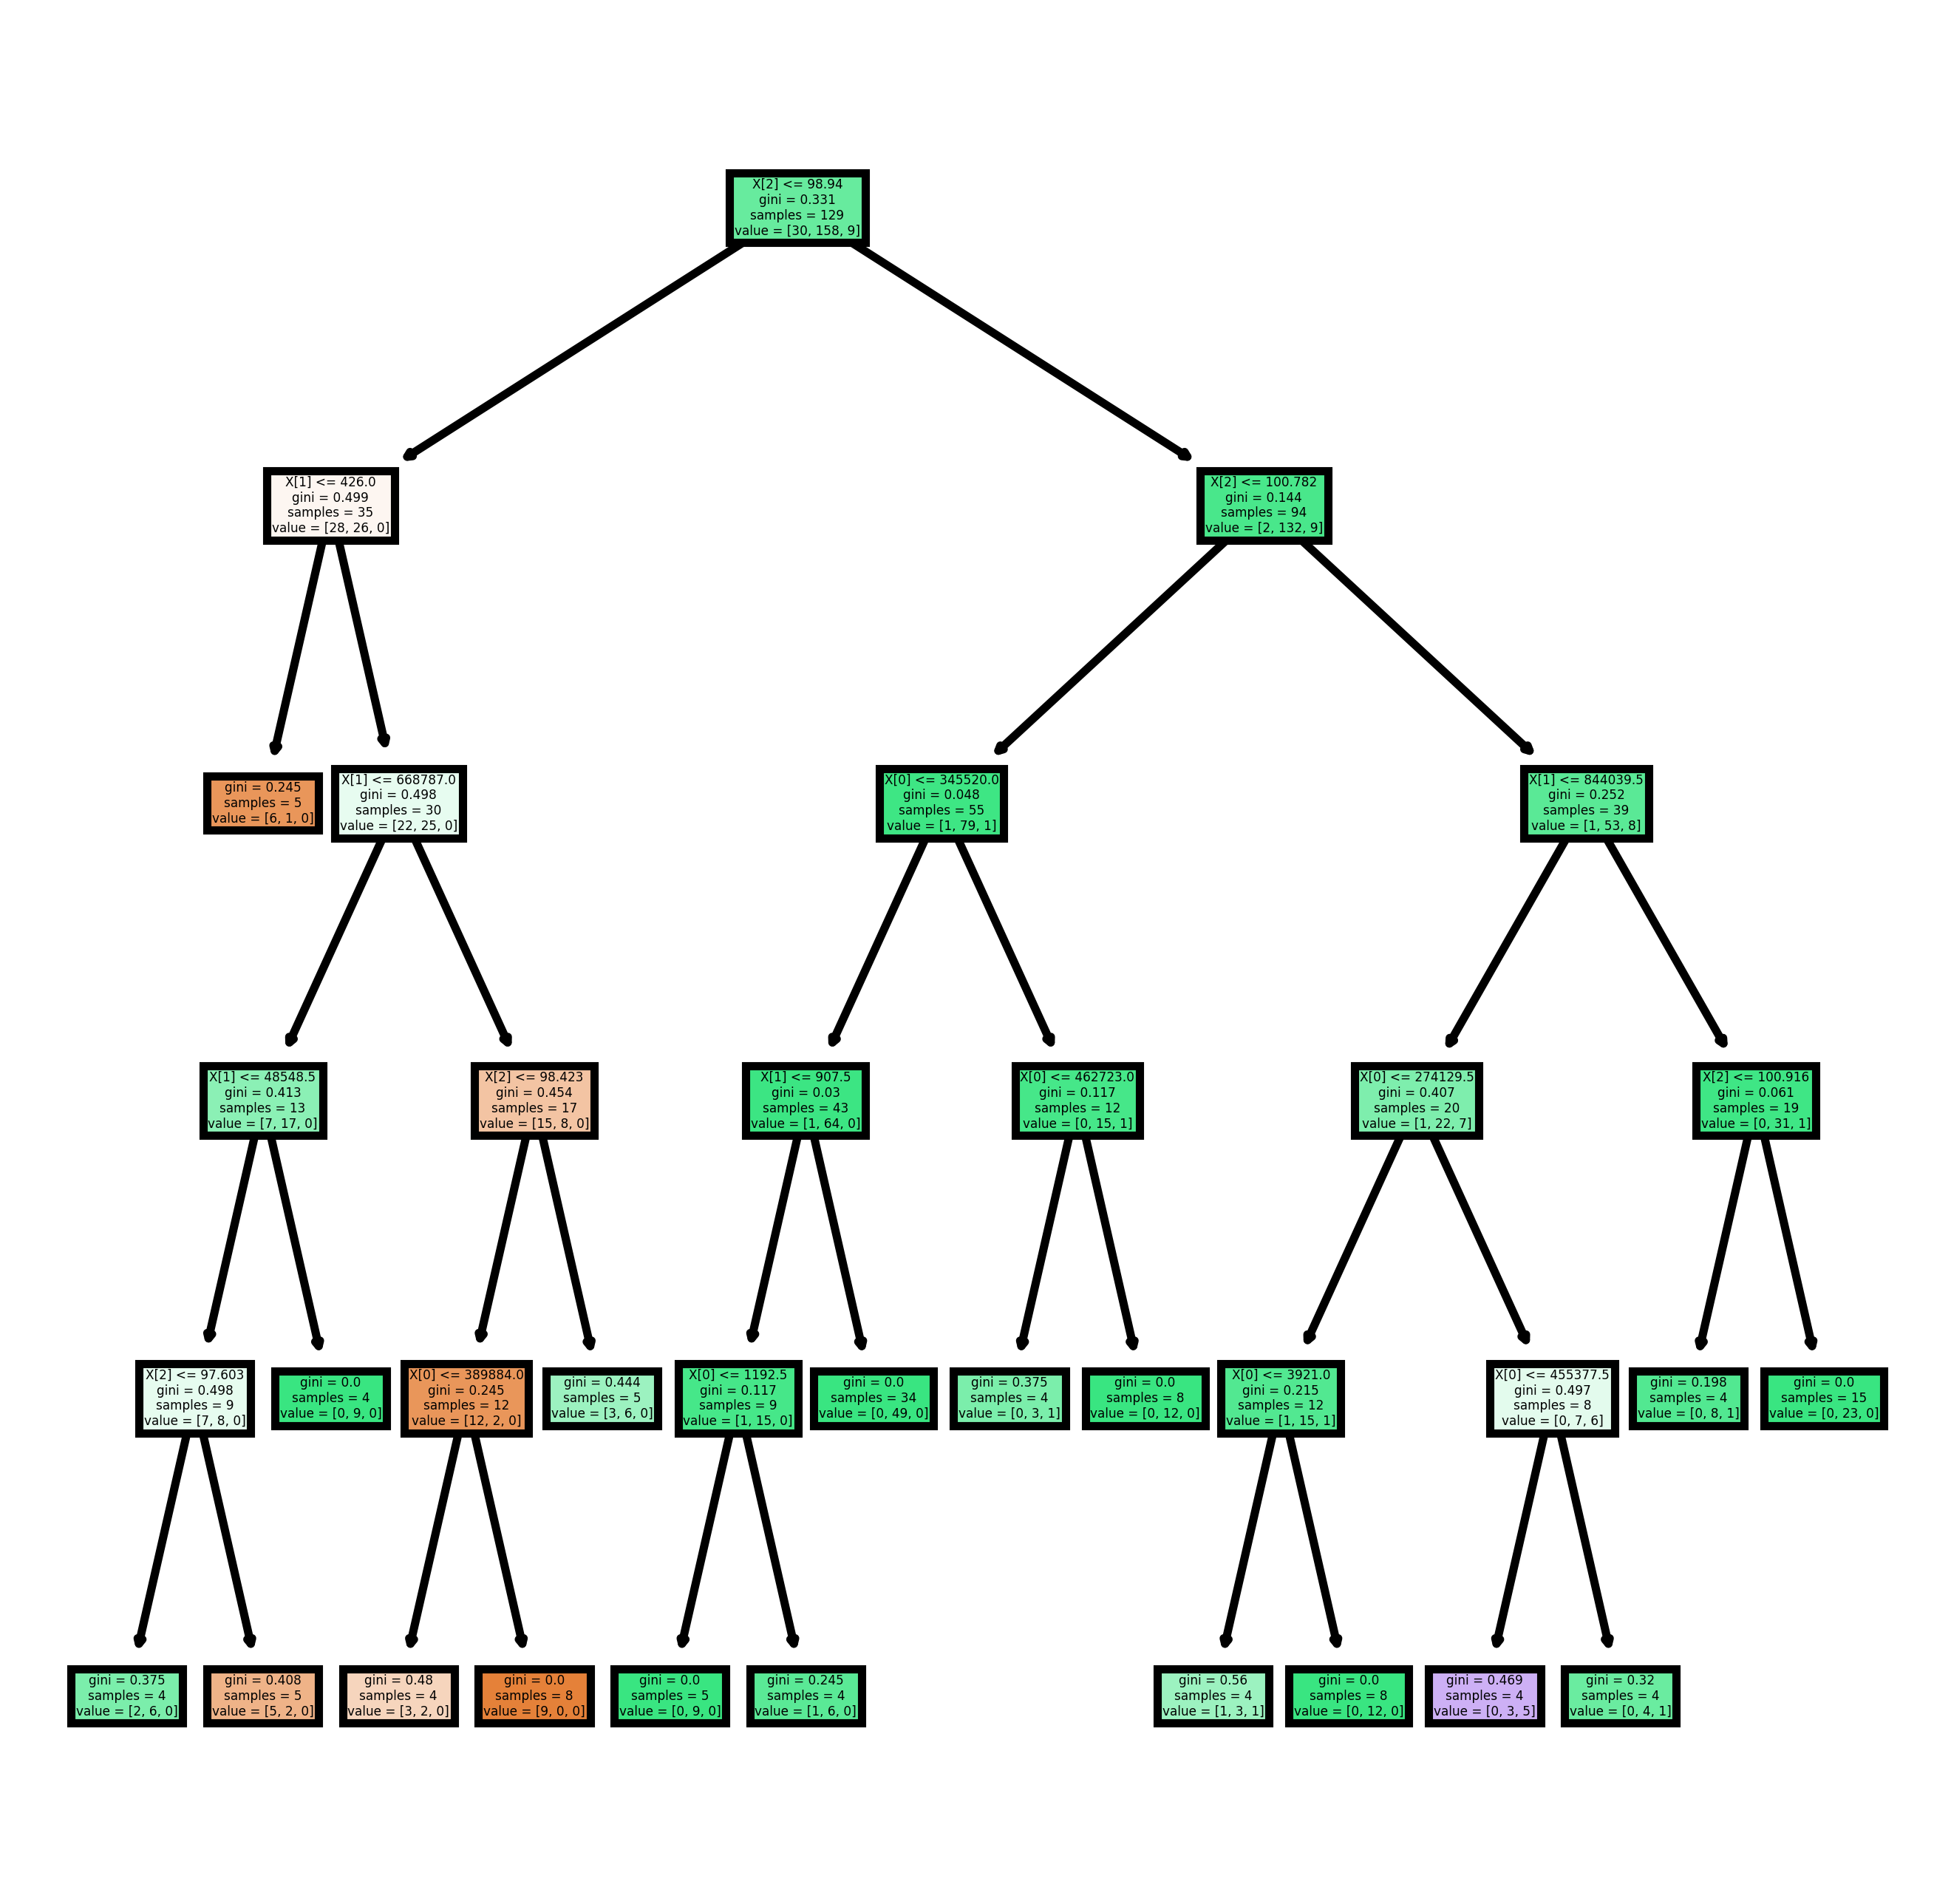

In [154]:
from sklearn import tree
import matplotlib.pyplot as plt

fn = ['time','ibm_vol','hp_vol','spread','spread_high'],
cn = ['1','0','-1'],
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(model.estimators_[0],
#                feature_names = fn, 
#                class_names = cn,
               filled = True);
fig.savefig('rf_individualtree.png')